# Introduction
In this notebook we generate plots to evaluate our Input and ChIP samples using output from ChIPQC v1.26.0

# Set Environment
Import the libaries need to handle html formats and data tables

In [10]:
from bs4 import BeautifulSoup # used to parse HTML
import pandas as pd # used to handle dataframes/tables
# used to make plots
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

the code below is used to parse tables in html

In [11]:
class HTMLTableParser:
       
        def parse_url(self, url):
            soup = BeautifulSoup(url, 'lxml')
            return [(table['id'],self.parse_html_table(table))\
                    for table in soup.find_all('table')]  
    
        def parse_html_table(self, table):
            n_columns = 0
            n_rows=0
            column_names = []
    
            # Find number of rows and columns
            # we also find the column titles if we can
            for row in table.find_all('tr'):
                
                # Determine the number of rows in the table
                td_tags = row.find_all('td')
                if len(td_tags) > 0:
                    n_rows+=1
                    if n_columns == 0:
                        # Set the number of columns for our table
                        n_columns = len(td_tags)
                        
                # Handle column names if we find them
                th_tags = row.find_all('th') 
                if len(th_tags) > 0 and len(column_names) == 0:
                    for th in th_tags:
                        column_names.append(th.get_text().strip())
    
            # Safeguard on Column Titles
            if len(column_names) > 0 and len(column_names) != n_columns:
                raise Exception("Column titles do not match the number of columns")
    
            columns = column_names if len(column_names) > 0 else range(0,n_columns)
            df = pd.DataFrame(columns = columns,
                              index= range(0,n_rows))
            row_marker = 0
            for row in table.find_all('tr'):
                column_marker = 0
                columns = row.find_all('td')
                for column in columns:
                    df.iat[row_marker,column_marker] = column.get_text().strip()
                    column_marker += 1
                if len(columns) > 0:
                    row_marker += 1
                    
            # Convert to float if possible
            for col in df:
                try:
                    df[col] = df[col].astype(float)
                except ValueError:
                    pass
            
            return df

hard-code the location of the ChIPQC results within the Github repo

In [12]:
indir="../data/ChIPQCreport"

# Summary Tables

## Input-Seq (20 Random Inputs)

In [13]:
input_names=["noMask","GS","BL"]
input_dir=["20inputs_noMask",
              "20inputs_gsMask",
              "20inputs_blMask"]
input_summary_df=None
for i in range(0,len(input_names)):
    iname = input_names[i]
    ichipqc = ("%s/%s/ChIPQC.html" % (indir,input_dir[i]))
    hp = HTMLTableParser()
    with open(ichipqc, 'r') as f:

        contents = f.read()

        soup = BeautifulSoup(contents, "html.parser")

        i_summary_table = soup.find_all('table')[0]
        i_summary_df = hp.parse_html_table(i_summary_table)
        i_summary_df["mask"]=iname
        if i == 0:
            input_summary_df = i_summary_df.copy()
        else:
            input_summary_df = input_summary_df.append(
                i_summary_df, ignore_index=True)

### SSD boxplot

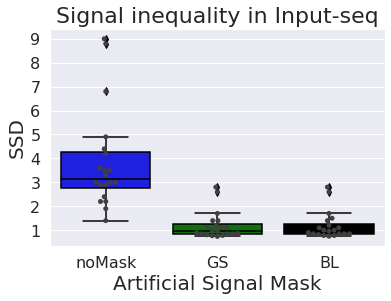

In [14]:
# generate boxplot
ax = sns.boxplot(x="mask", y="SSD", 
                 palette=sns.color_palette(["blue","green","black"]),
                 data=input_summary_df)
# use swarmplot() to show the data points on top of the box plots
ax = sns.swarmplot(x="mask", y="SSD", data=input_summary_df, color=".25")
# label each integer on the y-axis
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
# set title and x label
ax.set_title('Signal inequality in Input-seq',fontsize=22)
ax.set_xlabel('Artificial Signal Mask',fontsize=20)
ax.set_ylabel('SSD',fontsize=20)
ax.tick_params(labelsize=16)

## ChIP-Seq (LFY, FD, and TFL1)

In [20]:
mask_list=["noMask","gsMask","blMask"]
mask_dic={"noMask":"noMask", 
          "gsMask":"GS",
          "blMask":"BL"}
dup_list=["wiDups"]
macs2_controls_list=["bestControlsV5"]

all_chip_summary_df=None
i=0
for mask in mask_list:
    for dup in dup_list:
        for mcontrol in macs2_controls_list:
            subdir=("chip_%s_%s_%s_extFragSize_qval10" % (mask, dup, mcontrol))
            chipqc_html = ("%s/%s/ChIPQC.html" % (indir,subdir))
            hp = HTMLTableParser()
            with open(chipqc_html, 'r') as f:
                contents = f.read()
                soup = BeautifulSoup(contents, "html.parser")

                chip_summary_table = soup.find_all('table')[0]
                chip_summary_df = hp.parse_html_table(chip_summary_table)
                chip_summary_df["mask"]=mask_dic[mask]
                chip_summary_df["dup"]=dup
                chip_summary_df["macs2_control"]=mcontrol
                if i == 0:
                    all_chip_summary_df = chip_summary_df.copy()
                else:
                    all_chip_summary_df = all_chip_summary_df.append(
                        chip_summary_df, ignore_index=True)
            i+=1

In [21]:
all_chip_summary_df

,ID,Tissue,Factor,Condition,Replicate,Reads,Dup%,ReadL,FragL,RelCC,SSD,RiP%,mask,dup,macs2_control
0,FD_C_R1,,FD,,1.0,5949585.0,42.0,145.0,291.0,0.68,4.6,7.20,noMask,wiDups,bestControlsV5
1,FD_C_R2,,FD,,2.0,9322318.0,32.0,147.0,299.0,0.57,4.7,1.70,noMask,wiDups,bestControlsV5
2,FD_ft10_tsf1_S_R1,,FD_ft10_tsf1,,1.0,10537976.0,86.0,99.0,242.0,3.60,5.2,18.00,noMask,wiDups,bestControlsV5
3,FD_ft10_tsf1_S_R2,,FD_ft10_tsf1,,2.0,12009748.0,86.0,99.0,222.0,2.80,6.2,24.00,noMask,wiDups,bestControlsV5
4,FD_S_R1,,FD,,1.0,10206920.0,96.0,100.0,212.0,3.30,9.1,25.00,noMask,wiDups,bestControlsV5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,TFL1_A_W_R2,,TFL1_A,,2.0,8922344.0,10.0,73.0,274.0,2.10,1.2,3.50,BL,wiDups,bestControlsV5
59,TFL1_B_W_R1,,TFL1_B,,1.0,10760842.0,25.0,74.0,285.0,2.30,1.8,9.90,BL,wiDups,bestControlsV5
60,TFL1_B_W_R2,,TFL1_B,,2.0,10358141.0,19.0,74.0,276.0,2.20,1.7,9.40,BL,wiDups,bestControlsV5
61,TFL1_fd_W_R1,,TFL1_fd,,1.0,8114667.0,30.0,72.0,146.0,0.98,1.2,0.17,BL,wiDups,bestControlsV5


In [24]:
TFL1_A_W_chipSummary_df = (
    all_chip_summary_df.loc[((all_chip_summary_df["ID"].str.contains("TFL1_A_W")) &
                         (all_chip_summary_df["macs2_control"]=="bestControlsV5")),:])

In [25]:
TFL1_A_W_chipSummary_df

,ID,Tissue,Factor,Condition,Replicate,Reads,Dup%,ReadL,FragL,RelCC,SSD,RiP%,mask,dup,macs2_control
15,TFL1_A_W_R1,,TFL1_A,,1.0,9751754.0,12.0,74.0,279.0,1.0,4.8,5.6,noMask,wiDups,bestControlsV5
16,TFL1_A_W_R2,,TFL1_A,,2.0,9197055.0,12.0,73.0,266.0,1.0,4.7,5.3,noMask,wiDups,bestControlsV5
36,TFL1_A_W_R1,,TFL1_A,,1.0,9535413.0,11.0,74.0,283.0,1.7,1.2,3.8,GS,wiDups,bestControlsV5
37,TFL1_A_W_R2,,TFL1_A,,2.0,8987277.0,10.0,73.0,274.0,2.0,1.2,3.4,GS,wiDups,bestControlsV5
57,TFL1_A_W_R1,,TFL1_A,,1.0,9466967.0,11.0,74.0,283.0,1.8,1.2,3.9,BL,wiDups,bestControlsV5
58,TFL1_A_W_R2,,TFL1_A,,2.0,8922344.0,10.0,73.0,274.0,2.1,1.2,3.5,BL,wiDups,bestControlsV5


Text(0, 0.5, 'RSC')

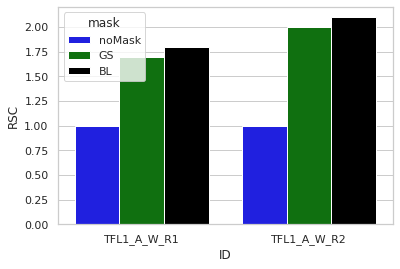

In [40]:
sns.set(font_scale=1.2)
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="ID", y="RelCC", 
                 hue="mask",
                 data=TFL1_A_W_chipSummary_df,
                 palette=sns.color_palette(["blue","green","black"]))
ax.set_ylabel("RSC")
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [36]:
if 1==0:
    sns.set(font_scale=1.2)
    g = sns.FacetGrid(TFL1_A_W_chipSummary_df, col="ID")
    g.map_dataframe(sns.barplot, x="ID", y="RelCC", 
                    hue="mask",
                    palette=sns.color_palette(["blue","green","black"]))
    g.set_axis_labels("", "RSC")
    g.set_titles(col_template="{col_name}")
    g.add_legend()

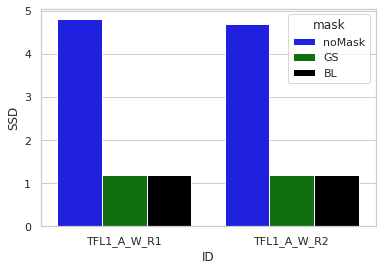

In [41]:
sns.set(font_scale=1.2)
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="ID", y="SSD", 
                 hue="mask",
                 data=TFL1_A_W_chipSummary_df,
                 palette=sns.color_palette(["blue","green","black"]))
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [42]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %conda  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%

In [ ]:
num1 = 1
num2 = 2